In [1]:
from scipy.io import loadmat
from numpy import linalg as LA
import numpy as np
from matplotlib import pyplot as plt

## Setup data and loss functions

Initialize the following Loss Functions on the Datasets located [here](https://github.com/rishabhk108/OptimizationML/tree/master/Assignments/data):

1. Logistic Loss

L2-regularized

$$L(w) = \sum_{i=1}^{n} log(1+ exp(-y_i w^{T} x_i)) + \lambda ||w||^{2}_{2}$$


$$\nabla_w L(w) = \sum_{i=1}^{n} \frac{-y_i x_i}{1+ exp(y_i w^{T} x_i)} + 2\lambda w $$



L1-regularized

$$L(w) = \sum_{i=1}^{n} log(1+ exp(-y_i w^{T} x_i)) + \lambda ||w||_{1}$$

$$\nabla_w L(w) = \sum_{i=1}^{n} \frac{-y_i x_i}{1+ exp(y_i w^{T} x_i)} + \mathbb{I}(w>0)\lambda - \mathbb{I}(w<0)\lambda $$

2. Hinge Loss

$$L(w) = \sum_{i=1}^{n} \max \{ 0, 1 - y_iw^{T}x_i\} + \lambda ||w||^{2}_{2}$$


In [2]:
X = loadmat(r"./data/train.mat")
y = np.loadtxt(r"./data/train.targets")
y = y = y.reshape(-1,1)
X = X['X'].todense()

In [3]:
def logistic_loss_l2(w, X, y, lamda):
    X_w = np.matmul(X,w)
    y_odot_X_w = np.multiply(y,X_w) #elementwise multiplication
    one_exp = np.logaddexp(0,-y_odot_X_w)
    f = np.sum(one_exp)
    f += lamda*np.dot(w.T,w)[0,0]
    X_transpose = X.transpose()
    g = np.matmul(X_transpose, (-1* y )/(1 + np.exp(np.longdouble(y_odot_X_w))))  + (2*lamda*w)
    return f, g

def logistic_loss_l1(w, X, y, lamda):
    X_w = np.matmul(X,w)
    y_odot_X_w = np.multiply(y,X_w) #elementwise multiplication
    one_exp = np.logaddexp(0,-y_odot_X_w)
    f = np.sum(one_exp)
    f += lamda*np.sum(np.abs(w))
    X_transpose = X.transpose()
    g = np.matmul(X_transpose, (-1* y )/(1 + np.exp(np.longdouble(y_odot_X_w))))  + lamda*np.sign(w)
    return f, g


def hinge_loss(w, X, y, lamda):
    X_w = np.matmul(X,w)
    y_odot_X_w = np.multiply(y,X_w) #elementwise multiplication
    one_minus_term = np.add(1,-y_odot_X_w)
    f = np.sum( np.maximum(0, one_minus_term) )
    f += lamda*np.sum(np.multiply(w,w))
    X_transpose = X.transpose()
    g = np.matmul(X_transpose, np.multiply( -1*y , np.double(y_odot_X_w < 1)))  + (2*lamda*w)
    return f, g

## Variants of Gradient Descent

Implement the following variants of Gradient Descent and test them out on the above loss functions.

### Gradient Descent with Fixed Learning rate $\alpha = 1e-05$

Algorithm of Gradient Descent:
1. Initialize weight $w_0$ randomly or set to 0
2. Initialize iteration $t = 0$
2. While $t$ is less than maximum iteration, $iter=250$
    * Compute gradient of the function $g = \nabla f(w_t)$
    * Shift the weights in gradient direction by step-size  (or learning rate)  $\alpha$
         $\quad w_{t+1} \leftarrow \, \, w_t - \alpha g$
    * Obtain the largest gradient
         $\quad w_{max} = max(g)$ or $LA.norm(g, np.inf)$
    * Break the loop if optimality condition is reached, i.e. if gradient is less than $optimal$
         $break \text{ if } \quad w_{max} < optimal$
    * increment $t$
2. return $w_{t+1}$



In [4]:
def gradient_descent(loss_fun, X, y, lamda=1, alpha=1e-05, iter=250, optimal=1e-2, w=None, verbosity=1, freq=20):
    if w is None:
        # initialize weights to zero
        w = np.zeros((X.shape[1],1))
    t = 0
    f_values = []
    while t < iter:
        # print(w.shape, X.shape, y.shape)
        f, g = loss_fun(w, X, y, lamda)
        f_values.append(f)
        w = w - alpha*g
        w_max = LA.norm(g, np.inf)
        if ((verbosity > 0) and (t % freq == 0)):
            print(f"Iteration {t}, Loss Value  {f}, Max Gradient {w_max}")
        if w_max < optimal:
            break
        t += 1
    return f_values, w


f_ll, parameters_ll = gradient_descent(logistic_loss_l2,X,y)
print("\n============\n")
f_hl, parameters_hl = gradient_descent(hinge_loss,X,y)


Iteration 0, Loss Value  8787.719955138986, Max Gradient 5886.5
Iteration 20, Loss Value  1125.85202314005, Max Gradient 87.89454181074298
Iteration 40, Loss Value  1048.1322591219807, Max Gradient 59.82390794479732
Iteration 60, Loss Value  1003.9905556795476, Max Gradient 44.997934593782425
Iteration 80, Loss Value  973.0583870600135, Max Gradient 35.72045847292656
Iteration 100, Loss Value  948.7428536238449, Max Gradient 32.578773203691156
Iteration 120, Loss Value  928.2787282079541, Max Gradient 30.24052961397645
Iteration 140, Loss Value  910.3200382783145, Max Gradient 28.434057952195843
Iteration 160, Loss Value  894.1330358660815, Max Gradient 26.98948124578824
Iteration 180, Loss Value  879.2811334821386, Max Gradient 25.798100523146985
Iteration 200, Loss Value  865.4856649310949, Max Gradient 24.788469220226176
Iteration 220, Loss Value  852.5579716003713, Max Gradient 23.912433985479865
Iteration 240, Loss Value  840.3637159284822, Max Gradient 23.136822178956397


Iterat

### Gradient Descent with Armijo Line-Search V1


Algorithm of Gradient Descent with line search:
1. Initialize weight $w_0$ randomly or set to 0
2. Initialize iteration $t = 0$, $\alpha= 0.9$
2. While $t$ is less than maximum iteration, $iter=250$
    * Compute gradient and the loss function value
       $f, g = f(w_t), \nabla f(w_t)$
    * **Line search** find best $\alpha$
        * while $f(w_t - \alpha g) > f(w_t) - \gamma \alpha ||g||^2$
            * $\alpha = \alpha/2$
    * Shift the weights in gradient direction by step-size  (or learning rate)  $\alpha$
         $\quad w_{t+1} \leftarrow \, \, w_t - \alpha g$
    * Obtain the largest gradient
         $\quad w_{max} = max(g)$ or $LA.norm(g, np.inf)$
    * Break the loop if optimality condition is reached, i.e. if gradient is less than $optimal$
         $break \text{ if } \quad w_{max} < optimal$
    * increment $t$
2. return $w_{t+1}$



In [5]:
def gradient_descent_armijov1(loss_fun, X, y, lamda=1, alpha=1, iter=250, optimal=1e-2, w=None, gamma=1e-4, verbosity=1, freq=20):
    if w is None:
        # initialize weights to zero
        w = np.zeros((X.shape[1],1))
    t = 0
    f_values = []
    f_evals = []
    back_trackings = []
    f_eval = 0
    num_back_tracking = 0
    while t < iter:
        # print(w.shape, X.shape, y.shape)
        f, g = loss_fun(w, X, y, lamda)
        f_eval += 1
        w_temp = w - alpha*g
        f_temp , g_temp =  loss_fun(w_temp, X, y, lamda)
        while f_temp > f - gamma*alpha*np.dot(g.T, g):
            alpha = alpha/2
            w_temp = w - alpha*g
            f_temp, g_temp = loss_fun(w_temp, X, y, lamda)
            f_eval += 1
            num_back_tracking += 1
        w = w - alpha*g
        w_max = LA.norm(g, np.inf)
        if ((verbosity > 0) and (t % freq == 0)):
            print(f"Iteration {t}, Loss Value  {f}, Alpha {alpha}, Function Eval {f_eval}, Backtracking count {num_back_tracking} ,Max Gradient {w_max}")
        if w_max < optimal:
            f_values.append(f)
            f_evals.append(f_eval)
            back_trackings.append(num_back_tracking)
            break
        f_values.append(f)
        f_evals.append(f_eval)
        back_trackings.append(num_back_tracking)
        t += 1
    return f_values, w, f_evals, back_trackings


f_ll_v1, parameters_ll_v1, fe_ll_v1, bt_ll_v1 = gradient_descent_armijov1(logistic_loss_l2,X,y, alpha=1)
print("\n============\n")
f_hl_v1, parameters_hl_v1, fe_hl_v1, bt_hl_v1 = gradient_descent_armijov1(hinge_loss,X,y, alpha=1)


<ipython-input-3-99a902f0372b>:8: RuntimeWarning: overflow encountered in exp
  g = np.matmul(X_transpose, (-1* y )/(1 + np.exp(np.longdouble(y_odot_X_w))))  + (2*lamda*w)


Iteration 0, Loss Value  8787.719955138986, Alpha 1.52587890625e-05, Function Eval 17, Backtracking count 16 ,Max Gradient 5886.5
Iteration 20, Loss Value  1084.6965173596875, Alpha 1.52587890625e-05, Function Eval 37, Backtracking count 16 ,Max Gradient 63.98829831563759
Iteration 40, Loss Value  1000.2280080461768, Alpha 1.52587890625e-05, Function Eval 57, Backtracking count 16 ,Max Gradient 43.25951986655052
Iteration 60, Loss Value  957.3471807337437, Alpha 1.52587890625e-05, Function Eval 77, Backtracking count 16 ,Max Gradient 34.42834686741984
Iteration 80, Loss Value  925.7971780001495, Alpha 1.52587890625e-05, Function Eval 97, Backtracking count 16 ,Max Gradient 30.097660390896593
Iteration 100, Loss Value  899.6743585539688, Alpha 1.52587890625e-05, Function Eval 117, Backtracking count 16 ,Max Gradient 27.467364906597716
Iteration 120, Loss Value  876.8997150568373, Alpha 1.52587890625e-05, Function Eval 137, Backtracking count 16 ,Max Gradient 25.613094163388123
Iteration


### Gradient Descent with Armijo Line-Search V2


Algorithm of Gradient Descent with line search:
1. Initialize weight $w_0$ randomly or set to 0
2. Initialize iteration $t = 0$, $\alpha= 0.9$
2. While $t$ is less than maximum iteration, $iter=250$
    * Compute gradient and the loss function value
       $f, g = f(w_t), \nabla f(w_t)$
    * Initialize line-search alpha $\alpha_s = \alpha$
    * **Line search** find best $\alpha_s$
        * while $f(w_t - \alpha_s g) > f(w_t) - \gamma \alpha_s ||g||^2$
            * $\alpha_s = \alpha_s/2$
    * Shift the weights in gradient direction by step-size  (or learning rate)  $\alpha$
         $\quad w_{t+1} \leftarrow \, \, w_t - \alpha_s g$
    * Obtain the largest gradient
         $\quad w_{max} = max(g)$ or $LA.norm(g, np.inf)$
    * Break the loop if optimality condition is reached, i.e. if gradient is less than $optimal$
         $break \text{ if } \quad w_{max} < optimal$
    * increment $t$
2. return $w_{t+1}$



In [6]:
def gradient_descent_armijov2(loss_fun, X, y, lamda=1, alpha=1, iter=250, optimal=1e-2, w=None, gamma=1e-4, verbosity=1, freq=20):
    if w is None:
        # initialize weights to zero
        w = np.zeros((X.shape[1],1))
    t = 0
    f_values = []
    f_evals = []
    back_trackings = []
    f_eval = 0
    num_back_tracking = 0
    while t < iter:
        # print(w.shape, X.shape, y.shape)
        f, g = loss_fun(w, X, y, lamda)
        f_eval += 1
        alpha_s = alpha
        w_temp = w - alpha_s*g
        f_temp , g_temp =  loss_fun(w_temp, X, y, lamda)
        while f_temp > f - gamma*alpha_s*np.dot(g.T, g):
            alpha_s = alpha_s/2
            w_temp = w - alpha_s*g
            f_temp, g_temp = loss_fun(w_temp, X, y, lamda)
            f_eval += 1
            num_back_tracking += 1
        w = w - alpha_s*g
        w_max = LA.norm(g, np.inf)
        if ((verbosity > 0) and (t % freq == 0)):
            print(f"Iteration {t}, Loss Value  {f}, Alpha {alpha_s}, Function Eval {f_eval}, Backtracking count {num_back_tracking} ,Max Gradient {w_max}")
        if w_max < optimal:
            f_values.append(f)
            f_evals.append(f_eval)
            back_trackings.append(num_back_tracking)
            break
        f_values.append(f)
        f_evals.append(f_eval)
        back_trackings.append(num_back_tracking)
        t += 1
    return f_values, w, f_evals, back_trackings

f_ll_v2, parameters_ll_v2, fe_ll_v2, bt_ll_v2  = gradient_descent_armijov2(logistic_loss_l2,X,y, alpha=1)
print("\n============\n")
f_hl_v2, parameters_hl_v2, fe_hl_v2, bt_hl_v2  = gradient_descent_armijov2(hinge_loss,X,y, alpha=1)

<ipython-input-3-99a902f0372b>:8: RuntimeWarning: overflow encountered in exp
  g = np.matmul(X_transpose, (-1* y )/(1 + np.exp(np.longdouble(y_odot_X_w))))  + (2*lamda*w)


Iteration 0, Loss Value  8787.719955138986, Alpha 1.52587890625e-05, Function Eval 17, Backtracking count 16 ,Max Gradient 5886.5
Iteration 20, Loss Value  917.1350516662803, Alpha 0.00048828125, Function Eval 326, Backtracking count 305 ,Max Gradient 25.51419647389782
Iteration 40, Loss Value  808.8584190702705, Alpha 0.0001220703125, Function Eval 641, Backtracking count 600 ,Max Gradient 25.059042939226742
Iteration 60, Loss Value  761.1156106708157, Alpha 3.0517578125e-05, Function Eval 956, Backtracking count 895 ,Max Gradient 50.24085651317331
Iteration 80, Loss Value  725.6322536031005, Alpha 3.0517578125e-05, Function Eval 1273, Backtracking count 1192 ,Max Gradient 44.45742792583765
Iteration 100, Loss Value  704.1039359121535, Alpha 3.0517578125e-05, Function Eval 1593, Backtracking count 1492 ,Max Gradient 42.13181825240118
Iteration 120, Loss Value  682.378078840374, Alpha 3.0517578125e-05, Function Eval 1913, Backtracking count 1792 ,Max Gradient 29.915744562577427
Iterati


### Gradient Descent with Armijo Line-Search V3


Algorithm of Gradient Descent with Armijo Line-Search V3:
1. Initialize weight $w_0$ randomly or set to 0
2. Initialize iteration $t = 0$, $\alpha= 1$
2. While $t$ is less than maximum iteration, $iter=250$
    * Compute gradient and the loss function value
       $f, g = f(w_t), \nabla f(w_t)$
    * Initialize line-search alpha $\alpha_s = \alpha$
    * **Line search** find best $\alpha_s$
        * while $f(w_t - \alpha_s g) > f(w_t) - \gamma \alpha_s ||g||^2$
            * $\alpha_s = \frac{\alpha_s^2 g^{T}g}{2(f(w_t-\alpha_s g) + \alpha_s g^{T}g - f(w_t))}$
    * Shift the weights in gradient direction by step-size  (or learning rate)  $\alpha$
         $\quad w_{t+1} \leftarrow \, \, w_t - \alpha_s g$
    * Obtain the largest gradient
         $\quad w_{max} = max(g)$ or $LA.norm(g, np.inf)$
    * Break the loop if optimality condition is reached, i.e. if gradient is less than $optimal$
         $break \text{ if } \quad w_{max} < optimal$
    * increment $t$
2. return $w_{t+1}$



In [7]:
def gradient_descent_armijov3(loss_fun, X, y, lamda=1, alpha=1, iter=250, optimal=1e-2, w=None, gamma=1e-4, verbosity=1, freq=20):
    if w is None:
        # initialize weights to zero
        w = np.zeros((X.shape[1],1))
    t = 0
    f_values = []
    f_evals = []
    back_trackings = []
    f_eval = 0
    num_back_tracking = 0
    while t < iter:
        # print(w.shape, X.shape, y.shape)
        f, g = loss_fun(w, X, y, lamda)
        f_eval += 1
        alpha_s = alpha
        w_temp = w - alpha_s*g
        f_temp , g_temp =  loss_fun(w_temp, X, y, lamda)
        while f_temp > f - gamma*alpha_s*np.dot(g.T, g):
            alpha_s = alpha_s*alpha_s*np.dot(g.T, g)[0,0]/(2*(f_temp + np.dot(g.T, g)[0,0]*alpha_s - f))
            w_temp = w - alpha_s*g
            f_temp, g_temp = loss_fun(w_temp, X, y, lamda)
            f_eval += 1
            num_back_tracking += 1
        w = w - alpha_s*g
        w_max = LA.norm(g, np.inf)
        if ((verbosity > 0) and (t % freq == 0)):
            print(f"Iteration {t}, Loss Value  {f}, Alpha {alpha_s}, Function Eval {f_eval}, Backtracking count {num_back_tracking} ,Max Gradient {w_max}")
        if w_max < optimal:
            f_values.append(f)
            f_evals.append(f_eval)
            back_trackings.append(num_back_tracking)
            break
        f_values.append(f)
        f_evals.append(f_eval)
        back_trackings.append(num_back_tracking)
        t += 1
    return f_values, w, f_evals, back_trackings

f_ll_v3, parameters_ll_v3,fe_ll_v3, bt_ll_v3  = gradient_descent_armijov3(logistic_loss_l2,X,y, alpha=1)
print("\n============\n")
f_hl_v3, parameters_hl_v3,fe_hl_v3, bt_hl_v3  = gradient_descent_armijov3(hinge_loss,X,y, alpha=1)

<ipython-input-3-99a902f0372b>:8: RuntimeWarning: overflow encountered in exp
  g = np.matmul(X_transpose, (-1* y )/(1 + np.exp(np.longdouble(y_odot_X_w))))  + (2*lamda*w)


Iteration 0, Loss Value  8787.719955138986, Alpha 1.7448726008135408e-05, Function Eval 14, Backtracking count 13 ,Max Gradient 5886.5
Iteration 20, Loss Value  949.4579437557504, Alpha 0.0022214477587168898, Function Eval 95, Backtracking count 74 ,Max Gradient 30.9481015407968
Iteration 40, Loss Value  753.7733930919915, Alpha 1.4672408306563962e-05, Function Eval 169, Backtracking count 128 ,Max Gradient 30.626715884006
Iteration 60, Loss Value  555.1348657606121, Alpha 1.732364493770049e-05, Function Eval 240, Backtracking count 179 ,Max Gradient 44.80256251740543
Iteration 80, Loss Value  370.51586914505765, Alpha 0.00017814760529887388, Function Eval 309, Backtracking count 228 ,Max Gradient 23.381354767277028
Iteration 100, Loss Value  344.40945301086606, Alpha 1.6616840021186326e-05, Function Eval 373, Backtracking count 272 ,Max Gradient 21.440912928258005
Iteration 120, Loss Value  337.2005660591949, Alpha 1.7807274242380088e-05, Function Eval 437, Backtracking count 316 ,Max

### Gradient Descent with Armijo Line-Search V4


Algorithm of Gradient Descent with Armijo Line-Search V4:
1. Initialize weight $w_0$ randomly or set to 0
2. Initialize iteration $t = 0$,
2. While $t$ is less than maximum iteration, $iter=250$
    * Compute gradient and the loss function value
       $f, g = f(w_t), \nabla f(w_t)$
    * If first iteration
        * $\alpha= \frac{1}{||g||}$
    * else
        * $\alpha = min(1,\frac{2(f_{old} - f)}{g^{T}g})$
    * **Line search** find best $\alpha$
        * while $f(w_t - \alpha g) > f(w_t) - \gamma \alpha ||g||^2$
            * $\alpha = \frac{\alpha^2 g^{T}g}{2(f(w_t-\alpha g) + \alpha g^{T}g - f(w_t))}$
    * Shift the weights in gradient direction by step-size  (or learning rate)  $\alpha$
         $\quad w_{t+1} \leftarrow \, \, w_t - \alpha g$
    * Obtain the largest gradient
         $\quad w_{max} = max(g)$ or $LA.norm(g, np.inf)$
    * Break the loop if optimality condition is reached, i.e. if gradient is less than $optimal$
         $break \text{ if } \quad w_{max} < optimal$
    * increment $t$
    * $f_{old} = f$
2. return $w_{t+1}$



In [8]:
def gradient_descent_armijov4(loss_fun, X, y, lamda=1, iter=250, optimal=1e-2, w=None, gamma=1e-4, verbosity=1, freq=20):
    if w is None:
        # initialize weights to zero
        w = np.zeros((X.shape[1],1))
    t = 0
    f_values = []
    f_evals = []
    back_trackings = []
    f_eval = 0
    num_back_tracking = 0
    while t < iter:
        # print(w.shape, X.shape, y.shape)
        f, g = loss_fun(w, X, y, lamda)
        f_eval += 1
        if t == 0:
            alpha = 1/LA.norm(g)
        else:
            alpha = min(1,2*(f_old - f)/np.dot(g.T, g)[0,0])
        w_temp = w - alpha*g
        f_temp , g_temp =  loss_fun(w_temp, X, y, lamda)
        while f_temp > f - gamma*alpha*np.dot(g.T, g):
            alpha = alpha*alpha*np.dot(g.T, g)[0,0]/(2*(f_temp + np.dot(g.T, g)[0,0]*alpha - f))
            w_temp = w - alpha*g
            f_temp, g_temp = loss_fun(w_temp, X, y, lamda)
            f_eval += 1
            num_back_tracking += 1
        w = w - alpha*g
        w_max = LA.norm(g, np.inf)
        if ((verbosity > 0) and (t % freq == 0)):
            print(f"Iteration {t}, Loss Value  {f}, Alpha {alpha}, Function Eval {f_eval}, Backtracking count {num_back_tracking} ,Max Gradient {w_max}")
        if w_max < optimal:
            f_values.append(f)
            f_evals.append(f_eval)
            back_trackings.append(num_back_tracking)
            break
        f_values.append(f)
        f_evals.append(f_eval)
        back_trackings.append(num_back_tracking)
        t += 1
        f_old = f
    return f_values, w, f_evals, back_trackings

f_ll_v4, parameters_ll_v4,fe_ll_v4, bt_ll_v4 = gradient_descent_armijov4(logistic_loss_l2,X,y)
print("\n============\n")
f_hl_v4, parameters_hl_v4, fe_hl_v4, bt_hl_v4 = gradient_descent_armijov4(hinge_loss,X,y)

Iteration 0, Loss Value  8787.719955138986, Alpha 1.4162318522628411e-05, Function Eval 1, Backtracking count 0 ,Max Gradient 5886.5
Iteration 20, Loss Value  992.2226379283536, Alpha 2.693040851778971e-05, Function Eval 25, Backtracking count 4 ,Max Gradient 56.93157543979735
Iteration 40, Loss Value  923.2924813064303, Alpha 5.034018316226718e-05, Function Eval 45, Backtracking count 4 ,Max Gradient 28.86740236800652
Iteration 60, Loss Value  876.6590941596615, Alpha 2.0959411627797566e-05, Function Eval 65, Backtracking count 4 ,Max Gradient 39.17095449344772
Iteration 80, Loss Value  838.4879852828826, Alpha 2.063171751930337e-05, Function Eval 85, Backtracking count 4 ,Max Gradient 37.15517798964047
Iteration 100, Loss Value  801.7055077139845, Alpha 0.00011638267209066039, Function Eval 105, Backtracking count 4 ,Max Gradient 17.92690873035211
Iteration 120, Loss Value  764.8891835783425, Alpha 2.7587713756043945e-05, Function Eval 126, Backtracking count 5 ,Max Gradient 28.12019

### Comparision of various Line search approaches with Gradient Descent

First, for hinge-loss

Text(0, 0.5, 'Loss Value')

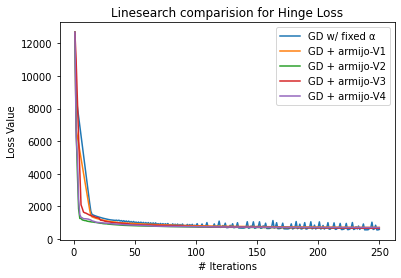

In [9]:

plt.plot(range(1,len(f_hl)+1), f_hl, label='GD w/ fixed α')
plt.plot(range(1,len(f_hl_v1)+1), f_hl_v1, label='GD + armijo-V1')
plt.plot(range(1,len(f_hl_v2)+1), f_hl_v2, label='GD + armijo-V2')
plt.plot(range(1,len(f_hl_v3)+1), f_hl_v3, label='GD + armijo-V3')
plt.plot(range(1,len(f_hl_v4)+1), f_hl_v4, label='GD + armijo-V4')
plt.legend()
plt.title("Linesearch comparision for Hinge Loss")
plt.xlabel("# Iterations")
plt.ylabel("Loss Value")
# plt.show()

We cannot see much, let-us zoom-in to find which worked best.

(0.0, 3000.0)

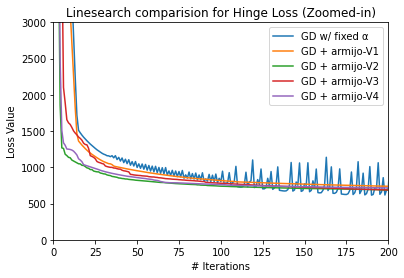

In [10]:
plt.plot(range(1,len(f_hl)+1), f_hl, label='GD w/ fixed α')
plt.plot(range(1,len(f_hl_v1)+1), f_hl_v1, label='GD + armijo-V1')
plt.plot(range(1,len(f_hl_v2)+1), f_hl_v2, label='GD + armijo-V2')
plt.plot(range(1,len(f_hl_v3)+1), f_hl_v3, label='GD + armijo-V3')
plt.plot(range(1,len(f_hl_v4)+1), f_hl_v4, label='GD + armijo-V4')
plt.legend()
plt.xlabel("# Iterations")
plt.title("Linesearch comparision for Hinge Loss (Zoomed-in)")
plt.ylabel("Loss Value")
plt.xlim((0,200))
plt.ylim((0,3000))
# plt.show()

Looks like v4 is best. But note that the above plots have number of iterations on the x-axis.
Let us compare against number of function evaluations

Text(0, 0.5, 'Loss Value')

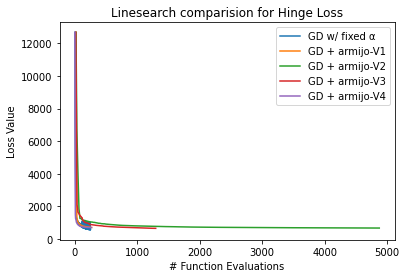

In [11]:


plt.plot(range(1,len(f_hl)+1), f_hl, label='GD w/ fixed α')
plt.plot(fe_hl_v1, f_hl_v1, label='GD + armijo-V1')
plt.plot(fe_hl_v2, f_hl_v2, label='GD + armijo-V2')
plt.plot(fe_hl_v3, f_hl_v3, label='GD + armijo-V3')
plt.plot(fe_hl_v4, f_hl_v4, label='GD + armijo-V4')
plt.legend()
plt.xlabel("# Function Evaluations")
plt.title("Linesearch comparision for Hinge Loss")
plt.ylabel("Loss Value")
# plt.show()

We cannot see much, let-us zoom-in.

(0.0, 6000.0)

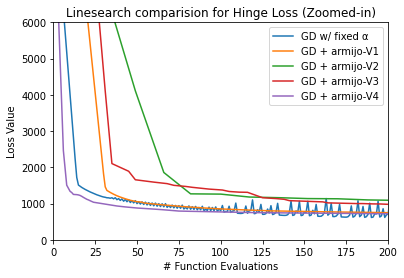

In [12]:

plt.plot(range(1,len(f_hl)+1), f_hl, label='GD w/ fixed α')
plt.plot(fe_hl_v1, f_hl_v1, label='GD + armijo-V1')
plt.plot(fe_hl_v2, f_hl_v2, label='GD + armijo-V2')
plt.plot(fe_hl_v3, f_hl_v3, label='GD + armijo-V3')
plt.plot(fe_hl_v4, f_hl_v4, label='GD + armijo-V4')
plt.legend()
plt.xlabel("# Function Evaluations")
plt.title("Linesearch comparision for Hinge Loss (Zoomed-in)")
plt.ylabel("Loss Value")
plt.xlim((0,200))
plt.ylim((0,6000))
# plt.show()




Looks like v4 was best and v2 is worst.

Lets make the same comparisons for Logistic Loss.

Text(0, 0.5, 'Loss Value')

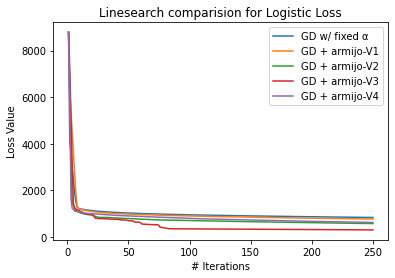

In [13]:
plt.plot(range(1,len(f_ll)+1), f_ll, label='GD w/ fixed α')
plt.plot(range(1,len(f_ll_v1)+1), f_ll_v1, label='GD + armijo-V1')
plt.plot(range(1,len(f_ll_v2)+1), f_ll_v2, label='GD + armijo-V2')
plt.plot(range(1,len(f_ll_v3)+1), f_ll_v3, label='GD + armijo-V3')
plt.plot(range(1,len(f_ll_v4)+1), f_ll_v4, label='GD + armijo-V4')
plt.legend()
plt.title("Linesearch comparision for Logistic Loss")
plt.xlabel("# Iterations")
plt.ylabel("Loss Value")
# plt.show()

(0.0, 3000.0)

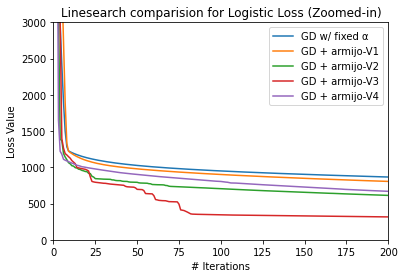

In [14]:


plt.plot(range(1,len(f_ll)+1), f_ll, label='GD w/ fixed α')
plt.plot(range(1,len(f_ll_v1)+1), f_ll_v1, label='GD + armijo-V1')
plt.plot(range(1,len(f_ll_v2)+1), f_ll_v2, label='GD + armijo-V2')
plt.plot(range(1,len(f_ll_v3)+1), f_ll_v3, label='GD + armijo-V3')
plt.plot(range(1,len(f_ll_v4)+1), f_ll_v4, label='GD + armijo-V4')
plt.legend()
plt.xlabel("# Iterations")
plt.title("Linesearch comparision for Logistic Loss (Zoomed-in)")
plt.ylabel("Loss Value")
plt.xlim((0,200))
plt.ylim((0,3000))
# plt.show()


Text(0, 0.5, 'Loss Value')

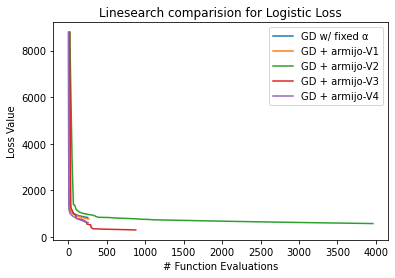

In [15]:


plt.plot(range(1,len(f_ll)+1), f_ll, label='GD w/ fixed α')
plt.plot(fe_ll_v1, f_ll_v1, label='GD + armijo-V1')
plt.plot(fe_ll_v2, f_ll_v2, label='GD + armijo-V2')
plt.plot(fe_ll_v3, f_ll_v3, label='GD + armijo-V3')
plt.plot(fe_ll_v4, f_ll_v4, label='GD + armijo-V4')
plt.legend()
plt.xlabel("# Function Evaluations")
plt.title("Linesearch comparision for Logistic Loss")
plt.ylabel("Loss Value")
# plt.show()



(0.0, 6000.0)

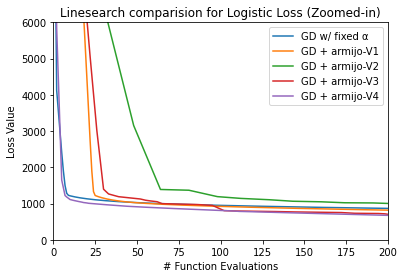

In [16]:

plt.plot(range(1,len(f_ll)+1), f_ll, label='GD w/ fixed α')
plt.plot(fe_ll_v1, f_ll_v1, label='GD + armijo-V1')
plt.plot(fe_ll_v2, f_ll_v2, label='GD + armijo-V2')
plt.plot(fe_ll_v3, f_ll_v3, label='GD + armijo-V3')
plt.plot(fe_ll_v4, f_ll_v4, label='GD + armijo-V4')
plt.legend()
plt.xlabel("# Function Evaluations")
plt.title("Linesearch comparision for Logistic Loss (Zoomed-in)")
plt.ylabel("Loss Value")
plt.xlim((0,200))
plt.ylim((0,6000))
# plt.show()

Above plots show armijo-v4 works best. So we will use it going ahead.

### Accelerated Gradient Descent

Gradient descent just relies on local gradient information. We can accelerate the descent with
momentum by remembering the direction of the descent. This is the main idea behind the GD with Heavy Ball Momentum
as well as Nesterov's Accelerated Gradient Descent.

Nesterov's Accelerated Gradient Descent uses a decay parameter $\lambda$

$$\lambda_o = 0, \lambda_t = \frac{1+\sqrt{1 + 4 \lambda_{t-1}^2}}{2}$$

And uses following update equation

$$y_{t+1} = w_t - \alpha_t \nabla f(w_t)$$
$$w_{t+1} = y_{t+1} - \frac{(1-\lambda_t) (y_{t+1} - y_t)}{\lambda_{t+1}}$$



Algorithm of Gradient Descent with Armijo Line-Search V4:
1. Initialize weight $w_0$ randomly or set to 0
2. Initialize iteration $t = 0$, $\lambda_t =0$
2. While $t$ is less than maximum iteration, $iter=250$
    * Compute  $\lambda_{t+1} = \frac{1+\sqrt{1 + 4 \lambda_t^2}}{2}$
    * Compute gradient and the loss function value
       $f, g = f(w_t), \nabla f(w_t)$
    * If first iteration
        * $\alpha= \frac{1}{||g||}$
    * else
        * $\alpha = min(1,\frac{2(f_{old} - f)}{g^{T}g})$
    * **Line search** find best $\alpha$
        * while $f(w_t - \alpha g) > f(w_t) - \gamma \alpha ||g||^2$
            * $\alpha = \frac{\alpha^2 g^{T}g}{2(f(w_t-\alpha g) + \alpha g^{T}g - f(w_t))}$
    * If first iteration
        * Shift the weight in gradient direction by step-size  (or learning rate)  $\alpha$
         $\quad w_{t+1} \leftarrow \, \, w_t - \alpha g$
         $y_{t+1} = w_{t+1}$
    * else
        * Shift the weight in accelerated gradient direction by step-size  (or learning rate)  $\alpha$
         $\quad y_{t+1} \leftarrow \, \, w_t - \alpha g$
         $\quad w_{t+1} \leftarrow \, \, y_{t+1} - \frac{(1-\lambda_t) (y_{t+1} - y_t)}{\lambda_{t+1}}$
    * Obtain the largest gradient
         $\quad w_{max} = max(g)$ or $LA.norm(g, np.inf)$
    * Break the loop if optimality condition is reached, i.e. if gradient is less than $optimal$
         $break \text{ if } \quad w_{max} < optimal$
    * increment $t$
    * $f_{old} = f$
2. return $w_{t+1}$



In [17]:
def acc_gradient_descent_armijov4(loss_fun, X, labels, lamda=1, iter=250, optimal=1e-2, w=None, gamma=1e-4, verbosity=1, freq=20):
    if w is None:
        # initialize weights to zero
        w = np.zeros((X.shape[1],1))
    t = 0
    f_values = []
    f_evals = []
    back_trackings = []
    f_eval = 0
    decay_rate = 0
    num_back_tracking = 0
    while t < iter:
        # print(w.shape, X.shape, y.shape)
        decay_rate_next = (1 + np.sqrt(1+4*decay_rate*decay_rate))/2
        f, g = loss_fun(w, X, labels, lamda)
        f_eval += 1
        if t == 0:
            alpha = 1/LA.norm(g)
        else:
            alpha = min(1,2*(f_old - f)/np.dot(g.T, g)[0,0])
        w_temp = w - alpha*g
        f_temp , g_temp =  loss_fun(w_temp, X, labels, lamda)
        while f_temp > f - gamma*alpha*np.dot(g.T, g):
            alpha = alpha*alpha*np.dot(g.T, g)[0,0]/(2*(f_temp + np.dot(g.T, g)[0,0]*alpha - f))
            w_temp = w - alpha*g
            f_temp, g_temp = loss_fun(w_temp, X, labels, lamda)
            f_eval += 1
            num_back_tracking += 1
        if t == 0:
            w = w - alpha*g
            y_next = w
        else:
            y_next = w - alpha*g
            w = y_next - ((1-decay_rate)*(y_next-y)/decay_rate_next)
        w_max = LA.norm(g, np.inf)
        if ((verbosity > 0) and (t % freq == 0)):
            print(f"Iteration {t}, Loss Value  {f}, Alpha {alpha}, Function Eval {f_eval}, Backtracking count {num_back_tracking} ,Max Gradient {w_max}")
        if w_max < optimal:
            f_values.append(f)
            f_evals.append(f_eval)
            back_trackings.append(num_back_tracking)
            break
        f_values.append(f)
        f_evals.append(f_eval)
        back_trackings.append(num_back_tracking)
        t += 1
        f_old = f
        y = y_next
        decay_rate = decay_rate_next
    return f_values, w, f_evals, back_trackings

f_ll_acc, parameters_ll_acc,fe_ll_acc, bt_ll_acc = acc_gradient_descent_armijov4(logistic_loss_l2,X,y)
print("\n============\n")
f_hl_acc, parameters_hl_acc, fe_hl_acc, bt_hl_acc = acc_gradient_descent_armijov4(hinge_loss,X,y)



Iteration 0, Loss Value  8787.719955138986, Alpha 1.4162318522628411e-05, Function Eval 1, Backtracking count 0 ,Max Gradient 5886.5
Iteration 20, Loss Value  849.4109943422105, Alpha 1.538872029386597e-05, Function Eval 34, Backtracking count 13 ,Max Gradient 51.3830308136158
Iteration 40, Loss Value  627.8609286624202, Alpha 2.5523154202219908e-05, Function Eval 73, Backtracking count 32 ,Max Gradient 19.656515194075695
Iteration 60, Loss Value  492.7923450275116, Alpha 2.8736329182312855e-05, Function Eval 113, Backtracking count 52 ,Max Gradient 15.170487355936757
Iteration 80, Loss Value  381.3257134637521, Alpha 3.3502606010052936e-05, Function Eval 153, Backtracking count 72 ,Max Gradient 11.158248657520398
Iteration 100, Loss Value  293.17755177142953, Alpha 3.928257249720107e-05, Function Eval 193, Backtracking count 92 ,Max Gradient 7.55862807485658
Iteration 120, Loss Value  230.02414265667943, Alpha 4.656507451870401e-05, Function Eval 233, Backtracking count 112 ,Max Gradi

Now lets compare the Accelerated gradient descent with gradient descent

Text(0, 0.5, 'Loss Value')

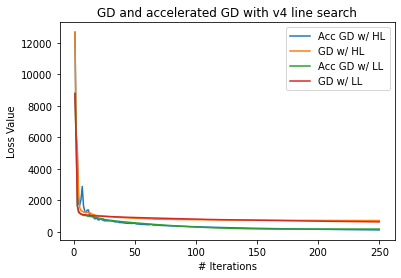

In [18]:
plt.plot(range(1,len(f_hl_acc)+1), f_hl_acc, label='Acc GD w/ HL')
plt.plot(range(1,len(f_hl_v4)+1), f_hl_v4, label='GD w/ HL')
plt.plot(range(1,len(f_ll_acc)+1), f_ll_acc, label='Acc GD w/ LL')
plt.plot(range(1,len(f_ll_v4)+1), f_ll_v4, label='GD w/ LL')
plt.legend()
plt.title("GD and accelerated GD with v4 line search")
plt.xlabel("# Iterations")
plt.ylabel("Loss Value")
# plt.show()




(0.0, 6000.0)

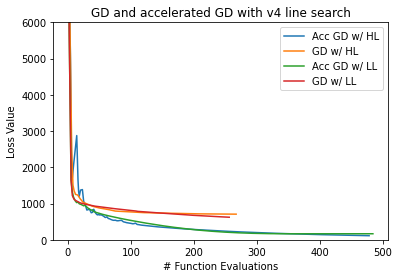

In [19]:

plt.plot(fe_hl_acc, f_hl_acc, label='Acc GD w/ HL')
plt.plot(fe_hl_v4, f_hl_v4, label='GD w/ HL')
plt.plot(fe_ll_acc, f_ll_acc, label='Acc GD w/ LL')
plt.plot(fe_ll_v4, f_ll_v4, label='GD w/ LL')
plt.legend()
plt.xlabel("# Function Evaluations")
plt.title("GD and accelerated GD with v4 line search")
plt.ylabel("Loss Value")
# plt.xlim((0,200))
plt.ylim((0,6000))
# plt.show()


Accelerated Gradient Descent works better for both hinge loss as well as logistic loss

### Conjugate Gradient Descent with Armijo Line-Search V4

Conjugate gradient descent updates $w$ in two steps

$$w_{k+1} = w_k - \alpha d_k$$

$$d_{k+1} = g_{k+1} + \beta_{k}d_{k}$$

Different variants of Conjugate GD use different $\beta$ updates. I implement the
**Fletcher-Reeves** CG, where

$$\beta_{k} = \frac{||\nabla f(w_k)||^2}{||\nabla f (x_{k-1})||^2}$$


Algorithm of Conjugate Gradient Descent with Armijo Line-Search V4:
1. Initialize weight $w_0$ randomly or set to 0
2. Initialize iteration $t = 0$, $d_{old} = w$, $\beta=0$
2. While $t$ is less than maximum iteration, $iter=250$
    * Compute gradient and the loss function value
       $f, g = f(w_t), \nabla f(w_t)$
    * If first iteration
        * $\alpha= \frac{1}{||g||}$
    * else
        * $\alpha = min(1,\frac{2(f_{old} - f)}{g^{T}g})$
    * $d = g + \beta d_{old}$
    * **Line search** find best $\alpha$
        * while $f(w_t - \alpha d) > f(w_t) - \gamma \alpha (g^{T}d)$
            * $\alpha = \frac{\alpha^2 g^{T}d}{2(f(w_t-\alpha g) + \alpha g^{T}d - f(w_t))}$
    * Shift the weights in gradient direction by step-size  (or learning rate)  $\alpha$
         $\quad w_{t+1} \leftarrow \, \, w_t - \alpha d$
    * Obtain the largest gradient
         $\quad w_{max} = max(g)$ or $LA.norm(g, np.inf)$
    * Break the loop if optimality condition is reached, i.e. if gradient is less than $optimal$
         $break \text{ if } \quad w_{max} < optimal$
    * increment $t$
    * $\beta = \frac{g^{T}g}{{g_{old}}^{T}g_{old}}$
    * $f_{old} = f$
    * $g_{old} = g$
    * $d_{old} = d$
2. return $w_{t+1}$



In [20]:
def conjugate_gradient_descent_armijov4(loss_fun, X, y, lamda=1, iter=250, optimal=1e-2, w=None, gamma=1e-4, verbosity=1, freq=20):
    if w is None:
        # initialize weights to zero
        w = np.zeros((X.shape[1],1))
    t = 0
    f_values = []
    f_evals = []
    back_trackings = []
    f_eval = 0
    num_back_tracking = 0
    beta= 0
    d_old = w
    while t < iter:
        # print(w.shape, X.shape, y.shape)
        f, g = loss_fun(w, X, y, lamda)
        f_eval += 1
        d = g + (beta * d_old)
        if t == 0:
            alpha = 1/LA.norm(g)
        else:
            alpha = min(1,2*(f_old - f)/np.dot(g.T, d)[0,0])
        w_temp = w - alpha*d
        f_temp , g_temp =  loss_fun(w_temp, X, y, lamda)
        while f_temp > f - gamma*alpha*np.dot(g.T, d):
            alpha = alpha*alpha*np.dot(g.T, d)[0,0]/(2*(f_temp + np.dot(g.T, d)[0,0]*alpha - f))
            w_temp = w - alpha*d
            f_temp, g_temp = loss_fun(w_temp, X, y, lamda)
            f_eval += 1
            num_back_tracking += 1
        w = w - alpha*d
        w_max = LA.norm(g, np.inf)
        if ((verbosity > 0) and (t % freq == 0)):
            print(f"Iteration {t}, Loss Value  {f}, Alpha {alpha}, Function Eval {f_eval}, Backtracking count {num_back_tracking} ,Max Gradient {w_max}")
        if w_max < optimal:
            f_values.append(f)
            f_evals.append(f_eval)
            back_trackings.append(num_back_tracking)
            break
        if t > 0:
            beta = np.dot(g.T,g)[0,0]/np.dot(g_old.T, g_old)[0,0]
        f_values.append(f)
        f_evals.append(f_eval)
        back_trackings.append(num_back_tracking)
        t += 1
        f_old = f
        g_old = g
        d_old = d
    return f_values, w, f_evals, back_trackings

f_ll_cgd, parameters_ll_cgd,fe_ll_cgd, bt_ll_cgd = gradient_descent_armijov4(logistic_loss_l2,X,y)
print("\n============\n")
f_hl_cgd, parameters_hl_cgd, fe_hl_cgd, bt_hl_cgd = conjugate_gradient_descent_armijov4(hinge_loss,X,y)




Iteration 0, Loss Value  8787.719955138986, Alpha 1.4162318522628411e-05, Function Eval 1, Backtracking count 0 ,Max Gradient 5886.5
Iteration 20, Loss Value  992.2226379283536, Alpha 2.693040851778971e-05, Function Eval 25, Backtracking count 4 ,Max Gradient 56.93157543979735
Iteration 40, Loss Value  923.2924813064303, Alpha 5.034018316226718e-05, Function Eval 45, Backtracking count 4 ,Max Gradient 28.86740236800652
Iteration 60, Loss Value  876.6590941596615, Alpha 2.0959411627797566e-05, Function Eval 65, Backtracking count 4 ,Max Gradient 39.17095449344772
Iteration 80, Loss Value  838.4879852828826, Alpha 2.063171751930337e-05, Function Eval 85, Backtracking count 4 ,Max Gradient 37.15517798964047
Iteration 100, Loss Value  801.7055077139845, Alpha 0.00011638267209066039, Function Eval 105, Backtracking count 4 ,Max Gradient 17.92690873035211
Iteration 120, Loss Value  764.8891835783425, Alpha 2.7587713756043945e-05, Function Eval 126, Backtracking count 5 ,Max Gradient 28.12019

### Barzilai-Borwein Gradient Descent

BB gradient descent uses same update equation as GD

$$w_{t+1} = w{t} - \alpha_t \nabla f (w_t)$$

With special value of $\alpha_t$

$$\alpha_t = \frac{s_k^{T} s_k}{s_k^{T} y_k}$$


Algorithm of BB Gradient Descent:
1. Initialize weight $w_0$ randomly or set to 0
2. Initialize iteration $t = 0$
2. $g_{old} = w_0$
2. While $t$ is less than maximum iteration, $iter=250$
    * Compute gradient of the function $g = \nabla f(w_t)$
    * $y = g- g_{old}$

    * if first iteration

       $\alpha = \frac{1}{||g||}$
    * else
       $\alpha = \frac{s^{T} y}{y^{T} y}$
    * Shift the weights in gradient direction by step-size  (or learning rate)  $\alpha$

         $\quad w_{t+1} \leftarrow \, \, w_t - \alpha g$
    * Obtain the largest gradient

         $\quad w_{max} = max(g)$ or $LA.norm(g, np.inf)$
    * Break the loop if optimality condition is reached, i.e. if gradient is less than $optimal$

         $break \text{ if } \quad w_{max} < optimal$
    * increment $t$
    * $s = -\alpha g$
    * $g_{old} = g$
2. return $w_{t+1}$


Algorithm of BB Gradient Descent with Armijo Line-Search V4:
1. Initialize weight $w_0$ randomly or set to 0
2. Initialize iteration $t = 0$,
2. $g_{old} = w_0$
2. While $t$ is less than maximum iteration, $iter=250$
    * Compute gradient and the loss function value

       $f, g = f(w_t), \nabla f(w_t)$
    * $y = g- g_{old}$
    * If first iteration
        * $\alpha= \frac{1}{||g||}$
    * else
        * $\alpha = \frac{s^{T} y}{y^{T} y}$
    * **Line search** find best $\alpha$
        * while $f(w_t - \alpha g) > f(w_t) - \gamma \alpha ||g||^2$
            * $\alpha = \frac{\alpha^2 g^{T}g}{2(f(w_t-\alpha g) + \alpha g^{T}g - f(w_t))}$
    * Shift the weights in gradient direction by step-size  (or learning rate)  $\alpha$
         $\quad w_{t+1} \leftarrow \, \, w_t - \alpha g$
    * Obtain the largest gradient
         $\quad w_{max} = max(g)$ or $LA.norm(g, np.inf)$
    * Break the loop if optimality condition is reached, i.e. if gradient is less than $optimal$
         $break \text{ if } \quad w_{max} < optimal$
    * increment $t$
    * $s = -\alpha g$
    * $f_{old} = f$
    * $g_{old} = g$
2. return $w_{t+1}$






In [21]:
def bb_gradient_descent(loss_fun, X, y, lamda=1, alpha=1e-05, iter=250, optimal=1e-2, w=None, verbosity=1, freq=20):
    if w is None:
        # initialize weights to zero
        w = np.zeros((X.shape[1],1))
    t = 0
    f_values = []
    g_old = w
    while t < iter:
        # print(w.shape, X.shape, y.shape)
        f, g = loss_fun(w, X, y, lamda)
        gdiff = g - g_old
        if t == 0:
            alpha = 1/LA.norm(g)
        else:
            alpha = np.dot(s.T,gdiff)[0,0]/np.dot(gdiff.T,gdiff)[0,0]
        f_values.append(f)
        w = w - alpha*g
        w_max = LA.norm(g, np.inf)
        if ((verbosity > 0) and (t % freq == 0)):
            print(f"Iteration {t}, Loss Value  {f}, Max Gradient {w_max}")
        if w_max < optimal:
            break
        t += 1
        s = -1*alpha*g
        g_old = g
    return f_values, w

def bb_gradient_descent_armijov4(loss_fun, X, y, lamda=1, iter=250, optimal=1e-2, w=None, gamma=1e-4, verbosity=1, freq=20):
    if w is None:
        # initialize weights to zero
        w = np.zeros((X.shape[1],1))
    t = 0
    f_values = []
    f_evals = []
    back_trackings = []
    f_eval = 0
    num_back_tracking = 0
    g_old = w
    while t < iter:
        # print(w.shape, X.shape, y.shape)
        f, g = loss_fun(w, X, y, lamda)
        f_eval += 1
        gdiff = g - g_old
        if t == 0:
            alpha = 1/LA.norm(g)
        else:
            alpha = np.dot(s.T,gdiff)[0,0]/np.dot(gdiff.T,gdiff)[0,0]
        w_temp = w - alpha*g
        f_temp , g_temp =  loss_fun(w_temp, X, y, lamda)
        while f_temp > f - gamma*alpha*np.dot(g.T, g):
            alpha = alpha*alpha*np.dot(g.T, g)[0,0]/(2*(f_temp + np.dot(g.T, g)[0,0]*alpha - f))
            w_temp = w - alpha*g
            f_temp, g_temp = loss_fun(w_temp, X, y, lamda)
            f_eval += 1
            num_back_tracking += 1
        w = w - alpha*g
        w_max = LA.norm(g, np.inf)
        if ((verbosity > 0) and (t % freq == 0)):
            print(f"Iteration {t}, Loss Value  {f}, Alpha {alpha}, Function Eval {f_eval}, Backtracking count {num_back_tracking} ,Max Gradient {w_max}")
        if w_max < optimal:
            f_values.append(f)
            f_evals.append(f_eval)
            back_trackings.append(num_back_tracking)
            break
        f_values.append(f)
        f_evals.append(f_eval)
        back_trackings.append(num_back_tracking)
        t += 1
        f_old = f
        s = -1*alpha*g
        g_old = g
    return f_values, w, f_evals, back_trackings


f_hl_bb, parameters_hl_bb = bb_gradient_descent(hinge_loss,X,y)
print("\n============\n")
f_hl_bb_v4, parameters_hl_bb_v4, fe_hl_bb_v4, bt_hl_bb_v4 = bb_gradient_descent_armijov4(hinge_loss,X,y)
print("\n============\n")
f_ll_bb, parameters_ll_bb = bb_gradient_descent(logistic_loss_l2,X,y)
print("\n============\n")
f_ll_bb_v4, parameters_ll_bb_v4, fe_ll_bb_v4, bt_ll_bb_v4 = bb_gradient_descent_armijov4(logistic_loss_l2,X,y)


Iteration 0, Loss Value  12678.0, Max Gradient 11773.0
Iteration 20, Loss Value  23703606.92028359, Max Gradient 801.3607298746585
Iteration 40, Loss Value  194045.47451269726, Max Gradient 143.92063981200155
Iteration 60, Loss Value  100343.42486697224, Max Gradient 84.58833595348239
Iteration 80, Loss Value  86993.04994326542, Max Gradient 86.34653751840523
Iteration 100, Loss Value  126796.86860020268, Max Gradient 131.79970866551363
Iteration 120, Loss Value  64093.6634905504, Max Gradient 92.44787395566522
Iteration 140, Loss Value  59284.98796986328, Max Gradient 87.42524095816118
Iteration 160, Loss Value  232601.30793553172, Max Gradient 119.86126857102586
Iteration 180, Loss Value  140631.31696235912, Max Gradient 101.80269029457918
Iteration 200, Loss Value  93368.65431735755, Max Gradient 77.51631463713765
Iteration 220, Loss Value  135133.56911712594, Max Gradient 118.22495018282073
Iteration 240, Loss Value  36474.05498692466, Max Gradient 63.15619400227307


Iteration 0, 

Comparison of Barzilai-Borwein GD with and without line-search for hinge-loss

Text(0, 0.5, 'Loss Value')

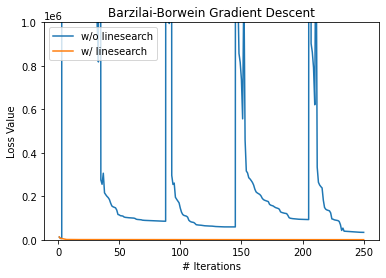

In [22]:

plt.plot(range(1,len(f_hl_bb)+1), f_hl_bb, label='w/o linesearch')
plt.plot(range(1,len(f_hl_bb_v4)+1), f_hl_bb_v4, label='w/ linesearch')
plt.legend()
plt.title("Barzilai-Borwein Gradient Descent")
plt.xlabel("# Iterations")
plt.ylim(0,1000000)
plt.ylabel("Loss Value")
# plt.show()

Text(0, 0.5, 'Loss Value')

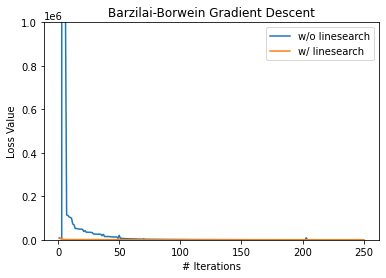

In [23]:

plt.plot(range(1,len(f_ll_bb)+1), f_ll_bb, label='w/o linesearch')
plt.plot(range(1,len(f_ll_bb_v4)+1), f_ll_bb_v4, label='w/ linesearch')
plt.legend()
plt.title("Barzilai-Borwein Gradient Descent")
plt.xlabel("# Iterations")
plt.ylim(0,1000000)
plt.ylabel("Loss Value")
# plt.show()



BB works better with line-search.

### Limited-memory BFGS

Quasi-Newton method use following template

1. Initialize weight $w_o$, an approximation of hessian matrix $B_o^{-1}$
2. Initialize iteration $t = 1$
3. While $t$ is less than maximum iteration, $iter=250$
    * Compute gradient and the loss function value
       $f, g = f(w_t), \nabla f(w_t)$
    * compute descent directions $z_{t-1}$

       $z_{t-1} = B_{t-1}^{-1} g$
    * Shift weight in the direction of descent

       $w_{t} = w_{t-1} - z_{t-1}$
    * Compute the new  approximation of hessian matrix

       $B_{t}^{-1} = \text{some function of } B_{t-1}^{-1}$

BFGS method uses following update equation for $B^{-1}$

$$B^{-1}_{t+1} = (I - \frac{s y^{T}}{y^{T}s})B^{-1}(I-\frac{ys^{T}}{y^{T}s})+\frac{ss^{T}}{y^{T}s}$$

where,
$s= w_t - w_{t-1}$

$y = \nabla f(w_{t}) - \nabla f(w_{t-1})$

So the Algorithm is

1. Initialize weight $w_o$, an approximation of hessian matrix $B_o^{-1}$
2. Initialize iteration $t = 1$
3. While $t$ is less than maximum iteration, $iter=250$
    * Compute gradient and the loss function value

       $f, g = f(w_{t-1}), \nabla f(w_{t-1})$
    * compute descent directions $z$

       $z = B_{t-1}^{-1} g$
    * Shift weight in the direction of descent
       $w_{t} = w_{t-1} -  z$
    * compute new gradient with $w_t$
        f_next, g_next $= f(w_t), \nabla f(w_t)$
    * compute $y = $ g_next $- g$
    * compute $s = -z$
    * Compute the new  approximation of hessian matrix
       $B_{t}^{-1} = (I - \frac{s y^{T}}{s^{T}y})B_{t-1}^{-1}(I-\frac{ys^{T}}{y^{T}s})+\frac{ss^{T}}{y^{T}s}$


In L-BFGS, the approximate hessian inverse update equation is modified from


$$B^{-1}_{t+1} = (I - \frac{s y^{T}}{y^{T}s})B^{-1}(I-\frac{ys^{T}}{y^{T}s})+\frac{ss^{T}}{y^{T}s}$$

to


$$B^{-1}_{t+1}g = p + (\alpha - \beta)s$$

where $$\alpha = \frac{s^Tg}{y^Ts}, q= g - \alpha y, p = B^{-1}q, \beta= \frac{y^{T}p}{y^{T}s} $$

So, the LBFGS algorithm is
1. Initialize weight $w_o$, an approximation of hessian matrix $B_o^{-1}$
2. Initialize iteration $t = 1$, number of historical iterations $m=30$
3. y_history, s_history = [], []
4. While $t$ is less than maximum iteration, $iter=250$
    * Compute gradient and the loss function value

       $f, g = f(w_{t-1}), \nabla f(w_{t-1})$
    * $z = $  LBFGS_descent_direction(y_history, s_history, g, m, t)
    * Shift weight in the direction of descent

       $w_{t} = w_{t-1} -  z$
    * compute new gradient with $w_t$

        f_next, g_next $= f(w_t), \nabla f(w_t)$
    * compute $y = $ g_next $- g$
    * y_history += [y]
    * s_history += [-z]

Algorithm to compute the descent direction in LBFGS is:

LBFGS_descent_direction(y, s, g, m, t)
1. $q = g$
2. $\alpha, \beta$ = {}, {}
2. if $t == 0$ return $q$
2. $l = \max(0, t-m)$
2. for $i$ = $t-1$ to $l$:
   * Compute $\alpha[i] = \frac{s[i]^{T}q}{y[i]^{T}s[i]}$
   * $q = q - \alpha[i] y[i]$
2. $h = \frac{s[l]^{T}y[l]}{y[l]^{T}y[l]}$
2. $p = h q$
2. for $i$ = $l$ to $t-1$:
   * Compute $\beta[i] = \frac{y[i]^{T}p}{y[i]^{T}s[i]}$
   * $p = p + (\alpha[i] - \beta[i])s[i]$
2. return $p$

Algorithm of LBFGS with Armijo Line-Search V4:

1. Initialize weight $w_0$ randomly or set to 0
2. Initialize iteration $t = 0$,
3. y_history, s_history = [], []
3. number of historical iterations $m=30$
2. While $t$ is less than maximum iteration, $iter=250$
    * Compute gradient and the loss function value
       $f, g = f(w_t), \nabla f(w_t)$
    * $z =$  LBFGS_descent_direction(y_history, s_history, g, m, t)
    * If first iteration
        * $\alpha= \frac{1}{||g||}$
    * else
        * $\alpha = min(1,\frac{2(f_{old} - f)}{g^{T}g})$
    * **Line search** find best $\alpha$
        * while $f(w_t - \alpha z) > f(w_t) - \gamma \alpha (g^T z)$
            * $\alpha = \frac{\alpha^2 g^{T}z}{2(f(w_t-\alpha z) + \alpha g^{T}z - f(w_t))}$

    * Shift the weight in gradient direction by step-size  (or learning rate)  $\alpha$

     $w_{t+1} \leftarrow \, \, w_t - \alpha z$

    * Obtain the largest gradient

     $\quad w_{max} = max(g)$ or $LA.norm(g, np.inf)$
    * Break the loop if optimality condition is reached, i.e. if gradient is less than $optimal$

         $break \text{ if } \quad w_{max} < optimal$
    * increment $t$
    * $f_{old} = f$
    * compute new gradient with $w_t$

       f_next, g_next $= f(w_{t+1}), \nabla f(w_{t+1})$
    * y_history +=  [g_next $- g$]
    * s_history += [$-\alpha z$]

2. return $w_{t+1}$



In [24]:
def LBFGS_descent_direction(y, s, g, l, t):
    q =  g
    alpha = {}
    beta = {}
    if t == 0:
        return q
    lowest_index = max(0, t-l)
    for i in range(t-1, lowest_index-1, -1):
        alpha[i] = np.dot(s[i].T,q)[0,0] / np.dot(y[i].T,s[i])[0,0]
        q = q - alpha[i]*y[i]
    h =  np.dot(s[lowest_index].T,y[lowest_index])[0,0] / np.dot(y[lowest_index].T,y[lowest_index])[0,0]
    p = h*q
    for i in range(lowest_index, t, 1):
            beta[i] = np.dot(y[i].T,p)[0,0]/np.dot(y[i].T,s[i])[0,0]
            p = p + (alpha[i] - beta[i])*s[i]
    return p

def LBFGS_armijov4(loss_fun, X, y, lamda=1, iter=250, optimal=1e-2, w=None, gamma=1e-4, l=30, verbosity=1, freq=20):
    if w is None:
        # initialize weights to zero
        w = np.zeros((X.shape[1],1))
    t = 0
    f_values = []
    f_evals = []
    back_trackings = []
    f_eval = 0
    num_back_tracking = 0
    y_history = []
    s_history = []
    while t < iter:
        # print(w.shape, X.shape, y.shape)
        f, g = loss_fun(w, X, y, lamda)
        f_eval += 1
        # f_next, g_next = loss_fun(w, X, y, lamda)
        if t > 0:
            y_history += [g - g_old]
        z = LBFGS_descent_direction(y_history, s_history, g, l, t)
        if t == 0:
            alpha = 1/LA.norm(g)
        else:
            alpha = min(1,2*(f_old - f)/np.dot(g.T, z)[0,0])
        w_temp = w - alpha*z
        f_temp , g_temp =  loss_fun(w_temp, X, y, lamda)
        while f_temp > f - gamma*alpha*np.dot(g.T, z):
            alpha = alpha*alpha*np.dot(g.T, z)[0,0]/(2*(f_temp + np.dot(g.T, z)[0,0]*alpha - f))
            w_temp = w - alpha*z
            f_temp, g_temp = loss_fun(w_temp, X, y, lamda)
            f_eval += 1
            num_back_tracking += 1
        w = w - alpha*z
        w_max = LA.norm(g, np.inf)
        if ((verbosity > 0) and (t % freq == 0)):
            print(f"Iteration {t}, Loss Value  {f}, Alpha {alpha}, Function Eval {f_eval}, Backtracking count {num_back_tracking} ,Max Gradient {w_max}")
        if w_max < optimal:
            f_values.append(f)
            f_evals.append(f_eval)
            back_trackings.append(num_back_tracking)
            break
        f_values.append(f)
        f_evals.append(f_eval)
        s_history +=  [-1*alpha*z]
        back_trackings.append(num_back_tracking)
        t += 1
        f_old = f
        g_old = g
    return f_values, w, f_evals, back_trackings

f_ll_lbfgs, parameters_ll_lbfgs,fe_ll_lbfgs, bt_ll_lbfgs = LBFGS_armijov4(logistic_loss_l2,X,y)
f_hl_lbfgs, parameters_hl_lbfgs,fe_hl_lbfgs, bt_hl_lbfgs = LBFGS_armijov4(hinge_loss,X,y)


Iteration 0, Loss Value  8787.719955138986, Alpha 1.4162318522628411e-05, Function Eval 1, Backtracking count 0 ,Max Gradient 5886.5
Iteration 20, Loss Value  867.8074579544625, Alpha 1, Function Eval 22, Backtracking count 1 ,Max Gradient 76.22663664621173
Iteration 40, Loss Value  351.09833204184287, Alpha 1, Function Eval 42, Backtracking count 1 ,Max Gradient 19.89628663517146
Iteration 60, Loss Value  203.56062126791045, Alpha 1, Function Eval 62, Backtracking count 1 ,Max Gradient 9.079198591760623
Iteration 80, Loss Value  165.79842909010756, Alpha 1, Function Eval 82, Backtracking count 1 ,Max Gradient 1.460855340192671
Iteration 100, Loss Value  163.63968270634703, Alpha 0.08092096852737414, Function Eval 103, Backtracking count 2 ,Max Gradient 0.7585207524453136
Iteration 120, Loss Value  163.300425646888, Alpha 1, Function Eval 123, Backtracking count 2 ,Max Gradient 0.13131987987618707
Iteration 140, Loss Value  163.27363492953688, Alpha 0.8059545335602694, Function Eval 14

### Comparison of following GD methods

1. Gradient Descent
2. Nesterov's Accelerated Gradient Descent
3. Conjugate Gradient Descent
4. Barzilai-Borwein Gradient descent
5. Limited memory BFGS

First, for hinge-loss

Text(0, 0.5, 'Loss Value')

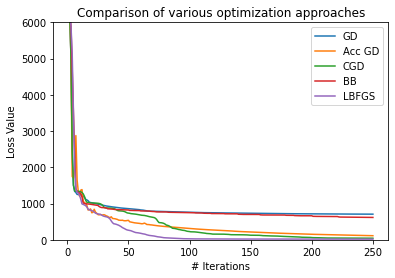

In [25]:
plt.plot(range(1,len(f_hl_v4)+1), f_hl_v4, label='GD')
plt.plot(range(1,len(f_hl_acc)+1), f_hl_acc, label='Acc GD')
plt.plot(range(1,len(f_hl_cgd)+1), f_hl_cgd, label='CGD')
plt.plot(range(1,len(f_hl_bb_v4)+1), f_hl_bb_v4, label='BB')
plt.plot(range(1,len(f_hl_lbfgs)+1), f_hl_lbfgs, label='LBFGS')
plt.legend()
plt.title("Comparison of various optimization approaches")
plt.xlabel("# Iterations")
plt.ylim(0,6000)
plt.ylabel("Loss Value")
# plt.show()



(0.0, 3000.0)

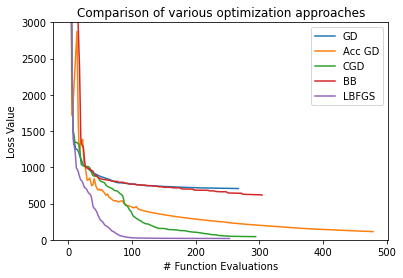

In [26]:

plt.plot(fe_hl_v4, f_hl_v4, label='GD')
plt.plot(fe_hl_acc, f_hl_acc, label='Acc GD')
plt.plot(fe_hl_cgd, f_hl_cgd, label='CGD')
plt.plot(fe_hl_bb_v4, f_hl_bb_v4, label='BB')
plt.plot(fe_hl_lbfgs, f_hl_lbfgs, label='LBFGS')
plt.legend()
plt.title("Comparison of various optimization approaches")
plt.xlabel("# Function Evaluations")
plt.ylabel("Loss Value")
plt.ylim(0,3000)
# plt.show()

Next for logistic-loss


Text(0, 0.5, 'Loss Value')

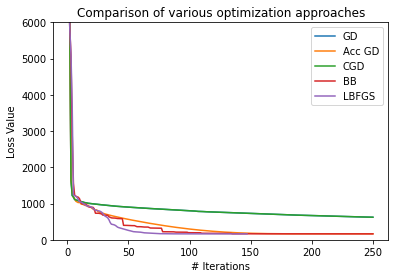

In [27]:
plt.plot(range(1,len(f_ll_v4)+1), f_ll_v4, label='GD')
plt.plot(range(1,len(f_ll_acc)+1), f_ll_acc, label='Acc GD')
plt.plot(range(1,len(f_ll_cgd)+1), f_ll_cgd, label='CGD')
plt.plot(range(1,len(f_ll_bb_v4)+1), f_ll_bb_v4, label='BB')
plt.plot(range(1,len(f_ll_lbfgs)+1), f_ll_lbfgs, label='LBFGS')
plt.legend()
plt.title("Comparison of various optimization approaches")
plt.xlabel("# Iterations")
plt.ylim(0,6000)
plt.ylabel("Loss Value")
# plt.show()



(0.0, 6000.0)

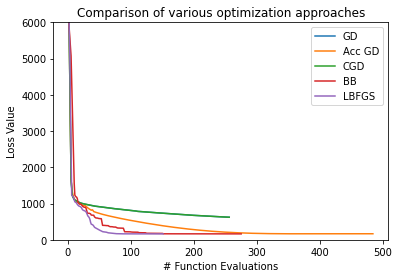

In [28]:

plt.plot(fe_ll_v4, f_ll_v4, label='GD')
plt.plot(fe_ll_acc, f_ll_acc, label='Acc GD')
plt.plot(fe_ll_cgd, f_ll_cgd, label='CGD')
plt.plot(fe_ll_bb_v4, f_ll_bb_v4, label='BB')
plt.plot(fe_ll_lbfgs, f_ll_lbfgs, label='LBFGS')
plt.legend()
plt.title("Comparison of various optimization approaches")
plt.xlabel("# Function Evaluations")
plt.ylabel("Loss Value")
plt.ylim(0,6000)
# plt.show()

### Proximal Gradient Descent

For composite functions made of two components,
for e.g. $f(w) + h(w)$, where f is convex and smooth but h is not differentiable,
We can use **proximal gradient descent**. Here, each iteration involves two steps

1. First step in the direction of gradient that minimizes f
2. Then compute Prox operator

So, the gradient update equation is now

$$w_{t+1} = \operatorname{prox}_{\alpha, h}(w_t - \alpha \nabla f (w_t))$$

For the logistic regression loss with L1 regularization, we can define the composite function as


$$L(w) = \underbrace{ \sum_{i=1}^{n} log(1+ exp(-y_i w^{T} x_i)) }_{f(w)}+ \underbrace{\lambda ||w||_{1}}_{h(w)}$$

$$\operatorname{prox}_{\alpha, \lambda ||w||}(z)$$

 $$ \quad \quad = z - \lambda \alpha \quad \text{  if } z > \lambda \alpha  $$

 $$ \quad \quad = z + \lambda \alpha \quad \text{  if } z < - \lambda \alpha  $$

 $$ \quad \quad = 0 \alpha \quad \text{  otherwise } $$

or equivalently

$$\operatorname{prox}_{\alpha, \lambda ||w||}(z) = \max(0, |z|-\lambda \alpha) \operatorname{sign}(z)$$


Algorithm of Gradient Descent:
1. Initialize weight $w_0$ randomly or set to 0
2. Initialize iteration $t = 0$
2. While $t$ is less than maximum iteration, $iter=250$
    * Compute gradient of the function $g = \nabla f(w_t)$
    * Shift the weights in gradient direction by step-size  (or learning rate)  $\alpha$
         $\quad w_{t+1} \leftarrow \, \, \operatorname{prox}(w_t - \alpha g)$
    * Obtain the largest gradient
         $\quad w_{max} = max(g)$ or $LA.norm(g, np.inf)$
    * Break the loop if optimality condition is reached, i.e. if gradient is less than $optimal$
         $break \text{ if } \quad w_{max} < optimal$
    * increment $t$
2. return $w_{t+1}$


Algorithm of Proximal Gradient Descent with Armijo Line-Search V4:
1. Initialize weight $w_0$ randomly or set to 0
2. Initialize iteration $t = 0$,
2. While $t$ is less than maximum iteration, $iter=250$
    * Compute gradient of $f$ and the loss function value
       $f, g = f(w_t)+h(w_t), \nabla f(w_t)$
    * If first iteration
        * $\alpha= \frac{1}{||g||}$
    * else
        * $\alpha = min(1,\frac{2(f_{old} - f)}{g^{T}g})$
    * **Line search** find best $\alpha$
        * while $f(\operatorname{prox}(w_t - \alpha g)) > f(w_t) - \gamma \alpha ||g||^2$
            * $\alpha = \frac{\alpha^2 g^{T}g}{2(f(\operatorname{prox}(w_t - \alpha g)) + \alpha g^{T}g - f(w_t))}$
    * Shift the weights in gradient direction by step-size  (or learning rate)  $\alpha$
         $\quad w_{t+1} \leftarrow \, \,\operatorname{prox}(w_t - \alpha g)$
    * Obtain the largest gradient
         $\quad w_{max} = max(g)$ or $LA.norm(g, np.inf)$
    * Break the loop if optimality condition is reached, i.e. if gradient is less than $optimal$
         $break \text{ if } \quad w_{max} < optimal$
    * increment $t$
    * $f_{old} = f$
2. return $w_{t+1}$


In [29]:
def prox_l1(z, lamda, alpha):
    l_a = lamda * alpha
    val = np.maximum( 0,np.abs(z) - l_a)
    return np.multiply(val, np.sign(z))

def prox_gradient_descent(loss_fun, X, y, lamda=1, alpha=1e-05, iter=250, optimal=1e-2, w=None, verbosity=1, freq=20):
    if w is None:
        # initialize weights to zero
        w = np.zeros((X.shape[1],1))
    t = 0
    f_values = []
    while t < iter:
        # print(w.shape, X.shape, y.shape)
        f, g = loss_fun(w, X, y, 0)
        f_values.append(f)
        w = prox_l1(w - alpha*g, lamda, alpha)
        w_max = LA.norm(g, np.inf)
        if ((verbosity > 0) and (t % freq == 0)):
            print(f"Iteration {t}, Loss Value  {f}, Max Gradient {w_max}")
        if w_max < optimal:
            break
        t += 1
    return f_values, w



def prox_gradient_descent_armijov4(loss_fun, X, y, lamda=1, iter=250, optimal=1e-2, w=None, gamma=1e-4, verbosity=1, freq=20):
    if w is None:
        # initialize weights to zero
        w = np.zeros((X.shape[1],1))
    t = 0
    f_values = []
    f_evals = []
    back_trackings = []
    f_eval = 0
    num_back_tracking = 0
    while t < iter:
        # print(w.shape, X.shape, y.shape)
        f, g = loss_fun(w, X, y, 0)
        f_eval += 1
        if t == 0:
            alpha = 1/LA.norm(g)
        else:
            alpha = min(1,2*(f_old - f)/np.dot(g.T, g)[0,0])
        w_temp = prox_l1(w - alpha*g,lamda, alpha)
        f_temp , g_temp =  loss_fun(w_temp, X, y, lamda)
        while f_temp > f - gamma*alpha*np.dot(g.T, g):
            alpha = alpha*alpha*np.dot(g.T, g)[0,0]/(2*(f_temp + np.dot(g.T, g)[0,0]*alpha - f))
            w_temp = prox_l1(w - alpha*g,lamda,alpha)
            f_temp, g_temp = loss_fun(w_temp, X, y, lamda)
            f_eval += 1
            num_back_tracking += 1
        w = prox_l1(w - alpha*g,lamda,alpha)
        w_max = LA.norm(g, np.inf)
        if ((verbosity > 0) and (t % freq == 0)):
            print(f"Iteration {t}, Loss Value  {f}, Alpha {alpha}, Function Eval {f_eval}, Backtracking count {num_back_tracking} ,Max Gradient {w_max}")
        if w_max < optimal:
            f_values.append(f)
            f_evals.append(f_eval)
            back_trackings.append(num_back_tracking)
            break
        f_values.append(f)
        f_evals.append(f_eval)
        back_trackings.append(num_back_tracking)
        t += 1
        f_old = f
    return f_values, w, f_evals, back_trackings

# f_ll_pgd, parameters_ll_pgd, fe_ll_pgd, bt_ll_pgd  = prox_gradient_descent_armijov4(logistic_loss_l1,X,y, lamda=1000)
f_ll_pgd, parameters_ll_pgd  = prox_gradient_descent(logistic_loss_l1,X,y, lamda=1000)
print("\n============\n")
f_ll_l1_gd, parameters_ll_l1_gd  = gradient_descent(logistic_loss_l1,X,y, lamda=1000)

Iteration 0, Loss Value  8787.719955138986, Max Gradient 5886.5
Iteration 20, Loss Value  2518.3108462941645, Max Gradient 1237.0273901687638
Iteration 40, Loss Value  2442.297673475815, Max Gradient 1166.775872011075
Iteration 60, Loss Value  2396.308825845869, Max Gradient 1118.1212697521728
Iteration 80, Loss Value  2359.384583396072, Max Gradient 1077.6327096195862
Iteration 100, Loss Value  2348.9978332415626, Max Gradient 1065.6382501300752
Iteration 120, Loss Value  2340.4823910447017, Max Gradient 1054.682624069259
Iteration 140, Loss Value  2337.7185953686017, Max Gradient 1049.863416331293
Iteration 160, Loss Value  2326.301923171424, Max Gradient 1036.156908020481
Iteration 180, Loss Value  2325.043864062457, Max Gradient 1033.2347803000407
Iteration 200, Loss Value  2322.4856285354185, Max Gradient 1028.8301826009802
Iteration 220, Loss Value  2318.149250154927, Max Gradient 1022.0751041755906
Iteration 240, Loss Value  2319.9028871049463, Max Gradient 1021.516913956057


I

Comparison of the GD and proximal-GD for L1-logistic loss with lamda=1000

Text(0, 0.5, 'Loss Value')

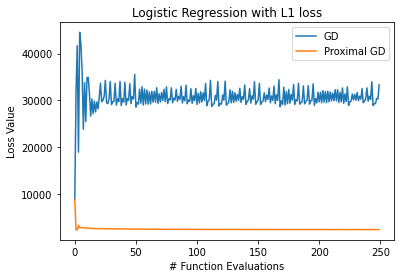

In [30]:
plt.plot(range(0,len(f_ll_l1_gd)), f_ll_l1_gd, label='GD')
plt.plot(range(0,len(f_ll_pgd)), f_ll_pgd, label='Proximal GD')
plt.legend()
plt.title("Logistic Regression with L1 loss")
plt.xlabel("# Function Evaluations")
plt.ylabel("Loss Value")